# Softmax Algorithm
epsilon-Greedy 알고리즘은 **탐색 시 무작위로 arm을 선택**하기 때문에, 그 arm의 **품질(보상의 기대값)** 에 관계없이 **동등하게 탐색**합니다.
이로 인해 arm 간의 **성능 차이를 고려하지 못하고**, **비효율적인 탐색**을 하게 됩니다.

#### 🔍 문제점

* 예시:

  * **Scenario A**: 보상 확률이 10% vs 13%
  * **Scenario B**: 보상 확률이 10% vs 99%
  * 두 경우 모두 epsilon-Greedy는 **열등한 arm을 탐색할 확률이 ε/2로 동일**합니다.

#### <그로 인한 문제>

1. **보상 차이가 작을 때**: 정확한 비교를 위해 **더 자주 탐색**해야 하지만, ε이 작으면 부족한 탐색이 이루어짐.
2. **보상 차이가 클 때**: 명백히 나쁜 arm도 **무의미하게 자주 탐색**되어, **보상이 낭비**됨.
3. 결국 epsilon-Greedy는 상황에 따라 **유연하게 탐색 빈도를 조절하지 못함**, 그래서 **효율적이지 않음**.

---

### ✅ 결론

epsilon-Greedy는 탐색 시 arm의 성능 차이를 고려하지 않기 때문에, **탐색의 효율성이 떨어지는 근본적인 한계**를 가지고 있습니다. 이 점은 reward 차이가 크거나 작을 때 모두 문제를 야기할 수 있습니다.

###  구조화된 탐색 (Structured Exploration)

* **Softmax 알고리즘**은 arm 간의 **추정 보상률(estimated reward)** 차이를 **탐색 시 고려**함.
* 즉, **성능이 더 좋은 arm을 더 자주 탐색**하게끔 설계됨.

#### 기본

* 각 arm의 선택 확률을 **그 추정 보상률에 비례**하게 설정.

  * 예: arm A의 보상이 rA, arm B의 보상이 rB일 때

    * arm A 선택 확률: `rA / (rA + rB)`
    * arm B 선택 확률: `rB / (rA + rB)`
* 이렇게 하면 **성능이 좋은 arm이 선택될 가능성이 높아지며**, **탐색이 더 전략적**이 됨.

---

### ✅ 결론

Softmax 알고리즘은 epsilon-Greedy의 무작위적 탐색 대신, **arm의 가치 차이를 반영한 구조화된 탐색**을 통해 더 똑똑하게 선택합니다.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import random

In [ ]:
def categorical_draw(probs):
  z = random.random()
  cum_prob = 0.0
  for i in range(len(probs)):
    prob = probs[i]
    cum_prob += prob
    if cum_prob > z:
      return i

  return len(probs) - 1

class AnnealingSoftmax:
  def __init__(self, counts, values):
    self.counts = counts
    self.values = values
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return

  def select_arm(self):
    t = sum(self.counts) + 1
    temperature = 1 / math.log(t + 0.0000001)

    z = sum([math.exp(v / temperature) for v in self.values])
    probs = [math.exp(v / temperature) / z for v in self.values]
    return categorical_draw(probs)

  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]

    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

Softmax 알고리즘이 이 문제를 어떻게 처리하는지에 대한 초기 직관을 얻기 위해, 각 팔(arm)을 그 추정 가치(estimated value)에 비례하여 선택한다고 가정 했을때.

예를 들어, 두 개의 팔 A와 B가 있다고 가정하고
그리고 과거의 경험을 통해 이 두 팔이 서로 다른 성공률 rA와 rB를 가지고 있다.

이러한 가정하에서, Softmax와 비슷한 알고리즘을 가장 단순하게 구현한다면 다음과 같이 작동할 것입니다:

팔 A를 선택할 확률:

 $ 𝑟𝐴/𝑟𝐴+𝑟𝐵 $


팔 B를 선택할 확률:

$ 𝑟𝐵/𝑟𝐴+𝑟𝐵​ $

즉, 각 팔의 선택 확률은 그 성공률에 비례합니다.



이 코드는 Softmax 알고리즘의 **가장 단순한 형태**인 비정규화된 비율 기반 탐색 (naive proportion-based exploration)을 구현한 것
## 🔍 코드 설명

###  `categorical_draw(probs)`

```python
def categorical_draw(probs):
    z = random.random()  # 0 ~ 1 사이의 난수 생성
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1
```

* **확률 분포(`probs`)에 따라 index를 무작위로 선택**하는 함수입니다.
* 예: `probs = [0.1, 0.3, 0.6]`이면, index 0은 10%, index 1은 30%, index 2는 60% 확률로 선택됨.

---

### `select_arm` 함수

```python
def select_arm(self):
    z = sum(self.values)  # 모든 arm의 추정값 합계
    probs = [v / z for v in self.values]  # 각 arm의 비율로 확률 분포 생성
    return categorical_draw(probs)
```

* 각 arm의 값을 합산한 뒤, **비율을 확률처럼 간주**하여 선택합니다.

  * 예: `self.values = [10, 30, 60]`이면 `probs = [0.1, 0.3, 0.6]`
* 즉, **보상이 클수록 선택 확률이 높아지는 구조**입니다.
* **Softmax 알고리즘에서 temperature 없이 지수 함수도 없이** 단순한 비율로만 arm 선택.

---

## ❗ 이 방식의 한계

* 보상의 **절대값 크기에 영향을 받음** (예: `[10, 30, 60]` vs `[1, 3, 6]`은 비슷하지만, `[0.1, 0.3, 0.6]`에서는 precision에 더 민감).
* **Softmax의 핵심인 `temperature` 조절이 없음**: 보상의 차이가 크거나 작아도 반응이 둔함.
* 그래서 일반적인 Softmax 알고리즘에서는 다음과 같이 지수 함수와 temperature를 포함시킵니다:

  ```python
  z = sum(math.exp(v / temperature) for v in self.values)
  probs = [math.exp(v / temperature) / z for v in self.values]
  ```

---

## ✅ 요약

| 항목 | 설명                                            |
| -- | --------------------------------------------- |
| 방식 | 보상의 비율에 따라 arm 선택                             |
| 장점 | 구현 간단, 직관적                                    |
| 단점 | temperature 없음, 비율에 너무 의존, precision 문제       |
| 권장 | 학습용 시뮬레이션에는 좋지만 실제 적용엔 Softmax full 버전이 더 안정적 |

In [ ]:
def categorical_draw(probs):
  z = random.random()
  cum_prob = 0.0
  for i in range(len(probs)):
   prob = probs[i]
   cum_prob += prob
   if cum_prob > z:
    return i

  return len(probs) - 1

def select_arm(self):
  z = sum(self.values)
  probs = [v / z for v in self.values]
  return categorical_draw(probs)

In [ ]:
import math
import random

def categorical_draw(probs):
  z = random.random()
  cum_prob = 0.0
  for i in range(len(probs)):
    prob = probs[i]
    cum_prob += prob
    if cum_prob > z:
      return i

  return len(probs) - 1

class Softmax:
  def __init__(self, temperature, counts, values):
    self.temperature = temperature
    self.counts = counts
    self.values = values
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return

  def select_arm(self):
    z = sum([math.exp(v / self.temperature) for v in self.values])
    probs = [math.exp(v / self.temperature) / z for v in self.values]
    return categorical_draw(probs)

  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]

    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

### 새로운 온도 매개변수: `tau (τ)`

우리는 이 온도 매개변수를 `tau`라고 부르며, 이를 도입하여 다음과 같은 Softmax 알고리즘을 구성:

---

### 🔁 Softmax 알고리즘 (두 개의 팔을 선택하는 경우)

1. **시점 T에서**, 두 개의 팔 중 하나를 아래 확률로 선택합니다:

   * **팔 A를 선택할 확률**:

     $$
     P(A) = \frac{e^{rA / \tau}}{e^{rA / \tau} + e^{rB / \tau}}
     $$

   * **팔 B를 선택할 확률**:

     $$
     P(B) = \frac{e^{rB / \tau}}{e^{rA / \tau} + e^{rB / \tau}}
     $$

   여기서 $rA$와 $rB$는 팔 A와 B의 **현재까지의 평균 보상(추정 가치)** 입니다.

2. 선택한 팔에 대해, 이전에 epsilon-Greedy 알고리즘에서 사용한 것과 **같은 방식으로 평균 보상 추정치를 업데이트**

---

### 요약

* **tau ↓ (작아질수록)** → 더 결정적인 선택 (좋은 팔 위주로)
* **tau ↑ (커질수록)** → 더 무작위적인 선택 (탐색 중심)

이 방식은 보상 값에 따라 행동을 **소프트하게(확률적으로)** 선택하면서도
탐색과 활용 사이에서 유연하게 조절할 수 있는 장점을 제공


tau는 Softmax 알고리즘의 동작 방식을 두 가지 극단적인 팔 선택 방식 사이의 연속선 어딘가로 이동시킬 수 있도록 해주는 역할을 합니다.

* 한쪽 극단에서는 tau = 0.0으로 설정합니다.
이 경우에는 **가장 높은 추정 가치를 가진 팔(arm)**을 완전히 결정론적으로 선택합니다.
 다시 말해, 항상 가장 좋은 것으로 판단되는 팔만 선택하게 됩니다.

* 반대쪽 극단에서는 tau = 무한대(∞)로 설정합니다.
이 경우에는 완전히 무작위적인 탐색이 이루어지며, 이는 앞서 살펴본 ε-탐욕(epsilon-greedy) 알고리즘의 무작위 탐색과 유사한 방식입니다.

이 매개변수를 **"온도"**라고 부르는 이유는 물리학에서 온도가 원자에 미치는 영향과 유사한 방식으로 Softmax의 선택 행동에 영향을 미치기 때문입니다:

* 낮은 온도에서는 원자들이 질서정연하게 행동하여 고체를 형성하듯이,
낮은 tau 값에서는 Softmax가 질서정연하게(=결정론적으로) 행동합니다.

* 반대로 높은 온도에서는 원자들이 무작위로 행동하여 기체를 형성하듯이,
높은 tau 값에서는 Softmax가 무작위적으로(=탐색적으로) 행동합니다.

이제 Softmax 알고리즘의 기본 아이디어를 이해했으니, 이전에 ε-탐욕 알고리즘을 테스트했던 시뮬레이션 환경에서 Softmax 알고리즘을 실험해보도록 합시다.

### 목적

* 여러 개의 확률적인 슬롯머신(arm) 중에서 **가장 좋은 arm**을 효율적으로 찾는 것이 목표입니다.
* **Softmax 알고리즘**을 이용해 각 arm의 추정 보상률을 바탕으로 확률적으로 arm을 선택합니다.

---

## 📘 주요 구성 설명

### 1. `BernoulliArm` 클래스

```python
class BernoulliArm:
    def __init__(self, p): self.p = p
    def draw(self): return 1 if random.random() < self.p else 0
```

* 보상이 `1`일 확률이 `p`, 보상이 `0`일 확률이 `1-p`인 **베르누이 분포** arm을 나타낸다.
* `draw()`는 arm을 한 번 당겼을 때의 보상을 반환

---

### 2. `Softmax` 알고리즘 클래스

```python
z = sum(math.exp(v / self.temperature) for v in self.values)
probs = [math.exp(v / self.temperature) / z for v in self.values]
```

#### 🔸 핵심 수식:

* **소프트맥스 선택 확률**:

  $$
  P(i) = \frac{e^{v_i / T}}{\sum_j e^{v_j / T}}
  $$
* `v_i`: arm i의 평균 보상 추정값 (value)
* `T` (temperature): **탐색/활용 균형 제어 파라미터**

  * T ↑ : 모든 arm에 거의 균등한 확률 → 탐색↑
  * T ↓ : 가장 큰 value를 가진 arm 위주로 선택 → 활용↑

---

### 3. `test_algorithm()` 함수

#### 반환값 구성:

```python
return [
    avg_chosen_arm,   # 어떤 arm이 선택됐는지
    avg_reward,       # 각 시점별 평균 보상
    cumulative_reward,# 누적 보상
    accuracy          # 최선의 arm을 맞췄는가
]
```

* `correct_arm[t] += 1` 은 해당 시점에 **최적 arm을 선택한 횟수 누적**
* 5000번 시뮬레이션 중 몇 번 최적 arm을 골랐는지를 바탕으로 **정확도 계산**

---
 * 목표: Softmax의 온도 파라미터를 [0.1, 0.2, 0.3, 0.4, 0.5] 로 바꿔가며 실험 수행

* 각 온도 설정마다 250 step의 성능 데이터를 저장

 ```python
 means = [0.1, 0.1, 0.1, 0.1, 0.9]

* 5개의 arm을 정의하고 각 arm의 보상률 지정
* 마지막 arm만 성능이 월등히 높음 → 최적 arm은 0.9

---

## 결과 해석

* **Best arm index:** 출력된 인덱스가 가장 높은 보상률을 가진 arm
* **Accuracy 그래프:** 시간이 지남에 따라 알고리즘이 최적 arm을 얼마나 잘 선택하는지 보여줌
* **Reward 그래프:** 시간별 보상 추세 (높을수록 잘 작동)
* **Cumulative reward:** 전체 성능 지표. 누적 보상이 높을수록 좋은 알고리즘

---

##  실험 목적

* Softmax의 **온도 파라미터** 변화에 따른 탐색/활용 트레이드오프 관찰
* Accuracy와 Cumulative Reward 사이의 관계 분석


In [ ]:
import random
import math

# Define necessary classes and functions (replacing core.py dependency)
class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        return 1 if random.random() < self.p else 0

# Find index of maximum value
def ind_max(x):
    return x.index(max(x))

# Draw based on categorical distribution
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i, prob in enumerate(probs):
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1


In [ ]:
# Softmax Algorithm
class Softmax:
    def __init__(self, temperature, counts=None, values=None):
        self.temperature = temperature
        self.counts = counts if counts is not None else []
        self.values = values if values is not None else []

    def initialize(self, n_arms):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.0 for _ in range(n_arms)]

    def select_arm(self):
        z = sum(math.exp(v / self.temperature) for v in self.values)
        probs = [math.exp(v / self.temperature) / z for v in self.values]
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / float(n)) * value + (1 / float(n)) * reward



In [ ]:
# Testing algorithm
def test_algorithm(algo, arms, num_sims, horizon, best_arm_index):
    chosen_arms = [0 for _ in range(horizon)]
    rewards = [0.0 for _ in range(horizon)]
    cumulative_rewards = [0.0 for _ in range(horizon)]
    correct_arm = [0.0 for _ in range(horizon)]

    for sim in range(num_sims):
        algo.initialize(len(arms))
        total_reward = 0
        for t in range(horizon):
            chosen_arm = algo.select_arm()
            reward = arms[chosen_arm].draw()
            algo.update(chosen_arm, reward)

            chosen_arms[t] += chosen_arm
            rewards[t] += reward
            total_reward += reward
            cumulative_rewards[t] += total_reward
            if chosen_arm == best_arm_index:
                correct_arm[t] += 1

    return [
        [float(chosen_arms[t]) / num_sims for t in range(horizon)],          # 평균 선택된 arm
        [float(rewards[t]) / num_sims for t in range(horizon)],              # 평균 보상
        [float(cumulative_rewards[t]) / num_sims for t in range(horizon)],   # 누적 보상
        [float(correct_arm[t]) / num_sims for t in range(horizon)]           # 정확도
    ]

In [ ]:
# Main execution
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = [BernoulliArm(mu) for mu in means]
best_arm_index = ind_max(means)

output_lines = []
for temperature in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = Softmax(temperature)
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, num_sims=5000, horizon=250, best_arm_index=best_arm_index)
    for t in range(len(results[0])):
        line = str(temperature) + "\t" + "\t".join([str(results[j][t]) for j in range(len(results))])
        output_lines.append(line)


In [ ]:
# 결과값 파일에 저장
output_path = "/content/drive/MyDrive/학연생 2025-1/standard_softmax_results.tsv"
with open(output_path, "w") as f:
    f.write("\n".join(output_lines))

print("Best arm index:", best_arm_index)
print("Results saved to:", output_path)


In [ ]:
pip install matplotlib pandas

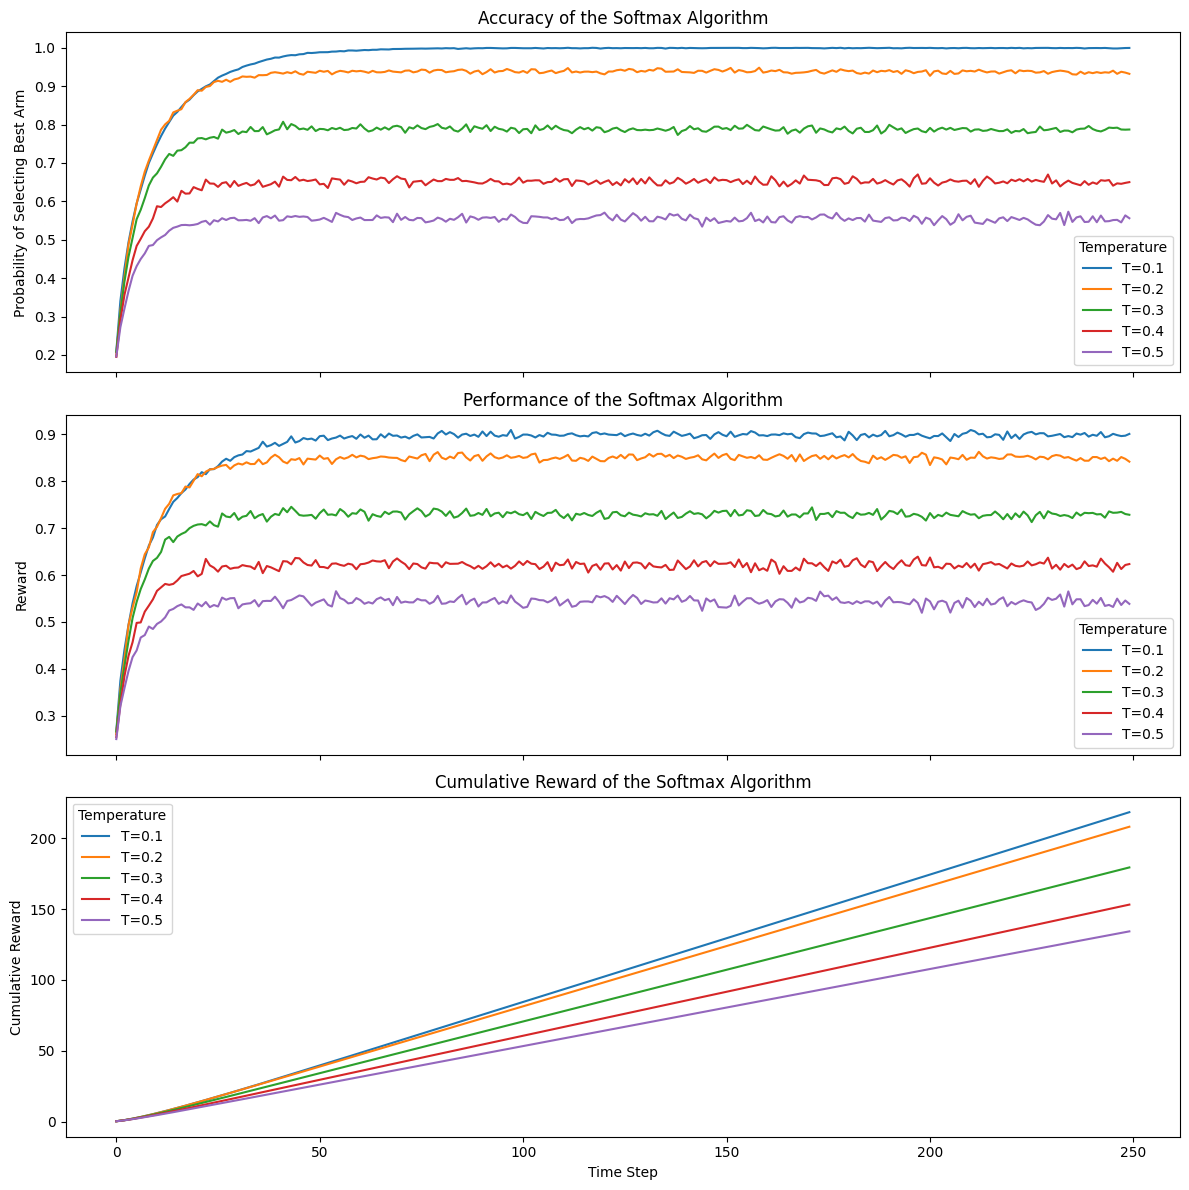

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로
file_path = "/content/drive/MyDrive/학연생 2025-1/standard_softmax_results.tsv"

# 데이터 불러오기
df = pd.read_csv(file_path, sep="\t", header=None,
                 names=["temperature", "chosen_arm", "reward", "cumulative_reward", "accuracy"])

# Temperature 별로 그룹화
grouped = df.groupby("temperature")

# Plot 설정
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# 각 그래프 그리기
for temp, group in grouped:
    x = group.index % 250
    axs[0].plot(x, group["accuracy"], label=f"T={temp}")  # ✅ 정확도는 저장된 accuracy 컬럼 사용
    axs[1].plot(x, group["reward"], label=f"T={temp}")
    axs[2].plot(x, group["cumulative_reward"], label=f"T={temp}")

# 정확도 그래프
axs[0].set_title("Accuracy of the Softmax Algorithm")
axs[0].set_ylabel("Probability of Selecting Best Arm")
axs[0].legend(title="Temperature")

# 성능 (즉시 보상) 그래프
axs[1].set_title("Performance of the Softmax Algorithm")
axs[1].set_ylabel("Reward")
axs[1].legend(title="Temperature")

# 누적 보상 그래프
axs[2].set_title("Cumulative Reward of the Softmax Algorithm")
axs[2].set_xlabel("Time Step")
axs[2].set_ylabel("Cumulative Reward")
axs[2].legend(title="Temperature")

plt.tight_layout()
plt.show()


### 정확도 그래프
* T=0.1: 가장 높은 정확도 → 거의 100%로 Best Arm을 선택함

* T 증가에 따라 정확도 감소:

  * T가 클수록 무작위성이 커지므로, 잘못된 팔을 선택할 확률도 커짐

  * T=0.5에서는 정확도가 50% 수준까지 떨어짐

✅ 결론: 낮은 T 값일수록 Best Arm을 더 자주 선택 (탐욕적 → exploitation 위주)

### 퍼포먼스
* T=0.1에서 보상이 가장 높음 (~0.9 근처)

* T가 증가할수록 보상이 점점 낮아짐

* T=0.5에서는 보상이 약 0.55 수준

✅이는 알고리즘이 최적의 팔을 덜 선택해서, 낮은 보상 팔에도 시간 낭비한 결과임

* 낮은 T (0.1~0.2) → 성능이 좋음 (정확도↑, 보상↑)

* 높은 T (0.4~0.5) → 탐색 많으나, 결과는 비효율적

Softmax에서 T는 성능과 탐색 사이의 trade-off를 조절하는 핵심 파라미터

### 누적 그래프
* T=0.1이 가장 높은 보상을 지속적으로 얻고 있으며, T 값이 작을수록 성능(누적 보상)이 더 우수함을 보여줍니다.

* T=0.5는 가장 낮은 성능을 보이고 있습니다.

#### Temperature의 의미 (Softmax에서):
Softmax 알고리즘에서 Temperature는 탐색과 이용의 균형을 조절

* 낮은 T (예: T=0.1):
→ Softmax 함수가 더 "날카로워"져서 보상이 높은 행동을 집중적으로 선택합니다 (탐욕적 선택).
→ → **이용(Exploitation)**에 치우침 → 더 많은 보상 획득.

* 높은 T (예: T=0.5):
→ Softmax 함수가 완만해져서 모든 행동을 더 고르게 선택합니다 (무작위성 증가).
→ → 탐색(Exploration) 증가 → 그러나 단기적으로 보상은 줄어듬.

✅ 결론:
이 실험에서는 **낮은 Temperature (특히 T=0.1)**일수록 성능이 좋습니다.

탐색보다 이용이 유리한 환경이라는 것을 암시합니다.

그러나 환경에 따라 T 값이 너무 낮으면 탐색 부족으로 국지 최적값에 빠질 위험도 있습니다. 따라서 실제 환경에서는 적절한 T 값의 튜닝이 중요합니다.

## Annealing Softmax 알고리즘
 탐색(exploration)과 활용(exploitation)의 균형을 조절하는 강화학습 기법 중 하나로, 시간이 지남에 따라 탐색을 줄이는 방식을 사용

* 목표:
Annealing Softmax 알고리즘을 실험적으로 검증

* 정확도(가장 좋은 arm 선택 비율), 평균 보상, 누적 보상 그래프 시각화

📘 실험 설정
K-armed bandit 환경 (예: 10개의 arm)

각 arm은 고정된 평균 보상을 가지고 있음 (ex: [0.1, 0.2, ..., 0.9])

AnnealingSoftmax 알고리즘이 반복적으로 arm을 선택하며 보상을 받고 업데이트함

전체 반복 수: 1000회

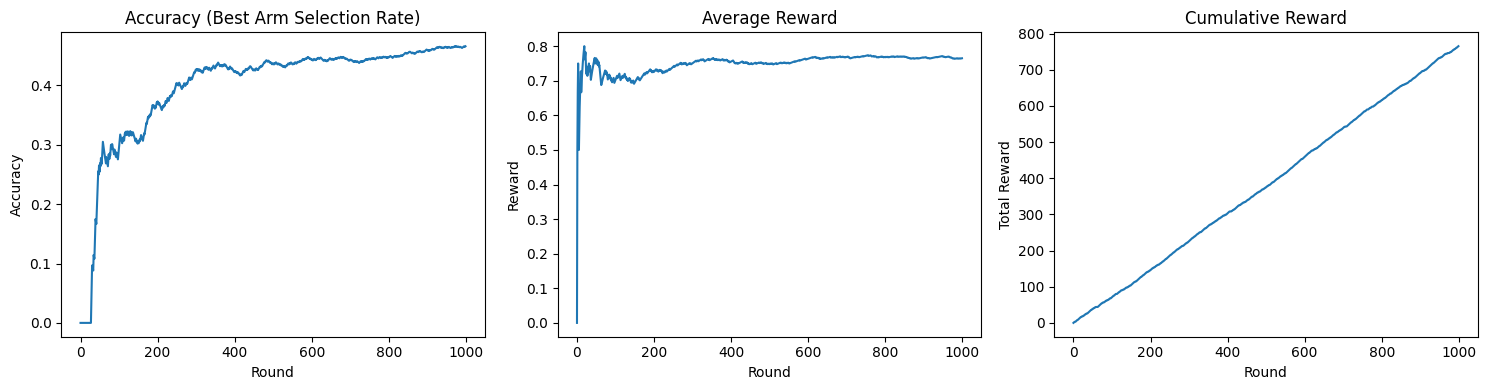

In [ ]:
import math
import random
import matplotlib.pyplot as plt

# 환경 설정: 각 arm이 갖는 실제 보상 확률 (0.1부터 0.9까지 9개)
true_rewards = [0.1 * i for i in range(1, 10)]
n_arms = len(true_rewards)
best_arm = true_rewards.index(max(true_rewards))  # 가장 보상이 높은 arm 인덱스

# 확률적으로 보상 생성 (Bernoulli 분포 기반)
def draw(arm):
    return 1 if random.random() < true_rewards[arm] else 0

# 확률분포를 기반으로 arm 하나를 선택하는 함수
def categorical_draw(probs):
    z = random.random()  # 0~1 사이 난수
    cum_prob = 0.0
    for i, prob in enumerate(probs):
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1  # 혹시라도 마지막까지 안 걸리면 마지막 arm 선택

# Annealing Softmax 알고리즘 정의
class AnnealingSoftmax:
    def __init__(self, counts, values):
        self.counts = counts  # 각 arm 선택 횟수
        self.values = values  # 각 arm의 현재까지 평균 보상

    def initialize(self, n_arms):
        # arm 개수만큼 리스트 초기화
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.0 for _ in range(n_arms)]

    def select_arm(self):
        # 전체 시도 횟수
        t = sum(self.counts) + 1
        # 시간에 따라 감소하는 온도(temperature) 설정
        temperature = 1 / math.log(t + 1e-7)

        # softmax 확률 계산
        z = sum([math.exp(v / temperature) for v in self.values])
        probs = [math.exp(v / temperature) / z for v in self.values]

        # 확률 기반으로 arm 선택
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        # 선택한 arm의 보상값으로 평균 보상 업데이트
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

# 실험 준비
algo = AnnealingSoftmax([], [])
algo.initialize(n_arms)

# 반복 설정
n_rounds = 1000
chosen_arms = []          # 선택된 arm 저장
rewards = []              # 받은 보상 저장
cumulative_rewards = []   # 누적 보상 저장
accuracy = []             # best arm 선택 비율 저장

total_reward = 0

# 알고리즘 실행
for t in range(n_rounds):
    arm = algo.select_arm()         # arm 선택
    reward = draw(arm)              # 보상 획득
    algo.update(arm, reward)        # 보상으로 학습

    # 기록 저장
    chosen_arms.append(arm)
    rewards.append(reward)
    total_reward += reward
    cumulative_rewards.append(total_reward)

    # 현재까지 best arm을 몇 번 선택했는지 정확도 계산
    accuracy.append(sum(1 for a in chosen_arms if a == best_arm) / (t + 1))

# 그래프 시각화
plt.figure(figsize=(15, 4))

# 1. 정확도 그래프: 얼마나 자주 최적 arm을 선택했는가
plt.subplot(1, 3, 1)
plt.plot(accuracy)
plt.title("Accuracy (Best Arm Selection Rate)")
plt.xlabel("Round")
plt.ylabel("Accuracy")

# 2. 평균 보상 그래프: 시간에 따른 평균 보상 추이
avg_rewards = [sum(rewards[:i+1]) / (i+1) for i in range(n_rounds)]
plt.subplot(1, 3, 2)
plt.plot(avg_rewards)
plt.title("Average Reward")
plt.xlabel("Round")
plt.ylabel("Reward")

# 3. 누적 보상 그래프: 받은 보상의 총합
plt.subplot(1, 3, 3)
plt.plot(cumulative_rewards)
plt.title("Cumulative Reward")
plt.xlabel("Round")
plt.ylabel("Total Reward")

plt.tight_layout()
plt.show()


  * Annealing: 시간에 따라 탐색을 줄이는 전략. temperature = 1 / log(t)로 감소시킴.

* Softmax: 각 arm의 현재 가치(value)를 확률적으로 선택.

* 실험 구성: draw()는 각 arm에 대해 Bernoulli 확률로 보상 결정.

* 정확도: 얼마나 자주 best arm을 선택했는가.

* 평균 보상: 전체 reward 평균.

* 누적 보상: 전체 받은 보상의 합.

✅ 1. Accuracy (정확도)
초기에는 많은 탐색을 통해 다양한 arm을 시도

시간이 지나면서 가장 높은 보상을 주는 arm(0.9)에 점점 집중

정확도 곡선이 점점 1에 가까워짐

✅ 2. Average Reward (평균 보상)
초기에 낮은 보상도 많이 받지만,

후반으로 갈수록 평균 보상이 상위 arm(예: 0.9)에 수렴

✅ 3. Cumulative Reward (누적 보상)
누적 보상은 점진적으로 증가

좋은 전략일수록 더 빠르게 우상향

